In [1]:
from ultralytics import YOLO
import cv2
import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline

In [2]:
dataset_dir = '/mnt/d/DataSets/whiteboard/'
data_yaml = dataset_dir + '/data.yaml'

In [15]:
model = YOLO("yolov8s-seg.pt")

In [13]:
results = model.train(
    data=str(data_yaml),
    task="segment",
    epochs=15,
    imgsz=960,
    batch=6,
    device="cuda",
    workers=6,
    cache=True,
    amp=True,
    patience=5,
    name="whiteboard_seg_45960"
)

print(f'Обучение завершено. Путь сохранения: {results.save_dir}')

New https://pypi.org/project/ultralytics/8.3.241 available 😃 Update with 'pip install -U ultralytics'
Ultralytics 8.3.240 🚀 Python-3.12.3 torch-2.8.0+cu129 CUDA:0 (NVIDIA GeForce RTX 3050 Ti Laptop GPU, 4096MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=6, bgr=0.0, box=7.5, cache=True, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/mnt/d/DataSets/whiteboard//data.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=15, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=960, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=runs/segment/whiteboard_seg_30960/weights/best.pt, momentum=0.937, mo

In [3]:
weights = 'runs/segment/whiteboard_seg_20640/weights/best.pt' 
model = YOLO(str(weights))

In [ ]:
def find_and_fix_perspective_from(img, target_class=None): 
    

In [92]:
test_image = 'tests/доска и экран с перекр.jpg'

pred = model.predict(
    source=str(test_image),
    conf=0.25,
    iou=0.5,
    device="cuda",
    save=False,
    verbose=False
)[0]

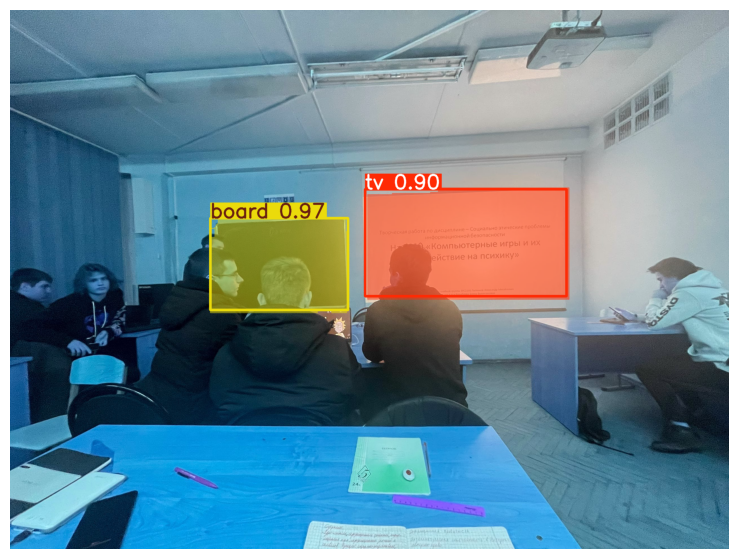

In [93]:
img = pred.plot()

plt.figure(figsize=(12, 7))
plt.imshow(img)
plt.axis('off')
plt.show()

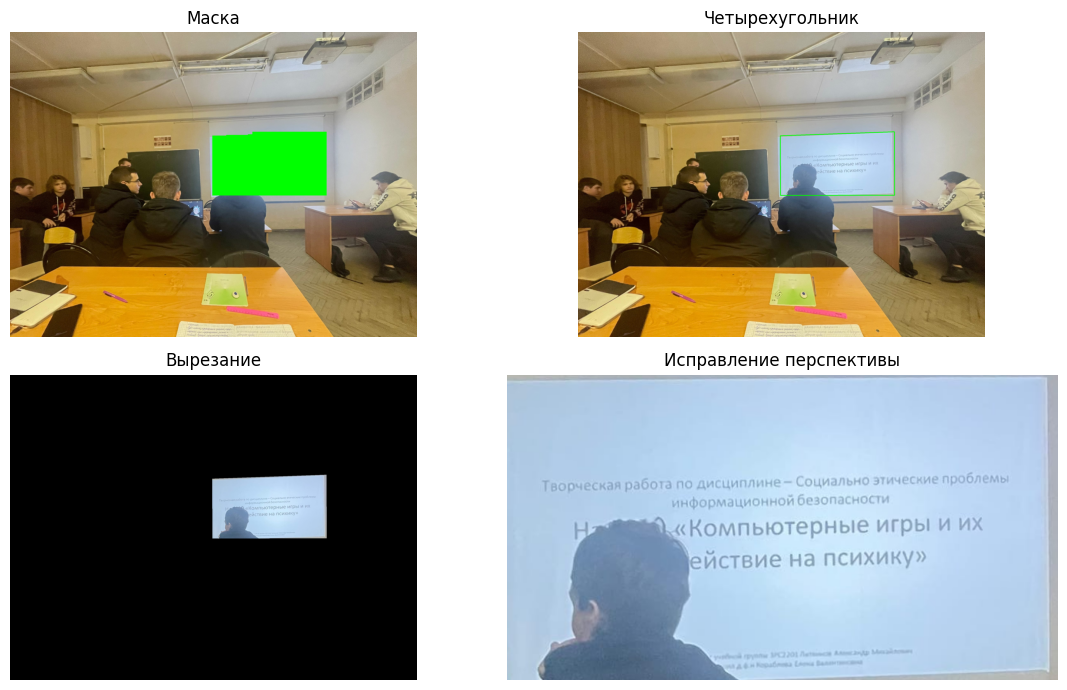

In [96]:
class_id = 0

orig_img = cv2.cvtColor(pred.orig_img, cv2.COLOR_BGR2RGB)
H, W = orig_img.shape[:2]

idxs = (pred.boxes.cls.cpu().numpy() == class_id).nonzero()[0] # индексы масок
best_id = idxs[pred.boxes.conf[idxs].argmax()] # индекс маски с максимальным conf
mask = pred.masks.data[best_id].cpu().numpy() # нужная маска
mask = cv2.resize(mask, (W, H), cv2.INTER_NEAREST) # ресайз маски под изображение


fill = orig_img.copy()
fill[mask == 1] = (0, 255, 0)


cnts, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
cnt = max(cnts, key=cv2.contourArea) # контур маски

# получение 4 углов аппроксимацией
peri = cv2.arcLength(cnt, True)
quad = cv2.approxPolyDP(cnt, 0.02 * peri, True)

if len(quad) == 4:
    box = quad.reshape(4, 2)
else:
    # если не вышло аппроксимацией
    rect = cv2.minAreaRect(cnt)
    box = cv2.boxPoints(rect)


box = box.astype(int) # четырехугольник

overlay = orig_img.copy()
cv2.drawContours(overlay, [box], 0, (0, 255, 0), 4)


poly_mask = np.zeros((H, W), dtype=np.uint8)
cv2.fillPoly(poly_mask, [box.astype(np.int32)], 255)
crop_poly = cv2.bitwise_and(orig_img, orig_img, mask=poly_mask)


pts = box.astype(np.float32)
s = pts.sum(1); d = np.diff(pts, axis=1).ravel()
tl = pts[np.argmin(s)]; br = pts[np.argmax(s)]
tr = pts[np.argmin(d)]; bl = pts[np.argmax(d)]
src = np.array([tl, tr, br, bl], np.float32)

w = int(max(np.linalg.norm(br-bl), np.linalg.norm(tr-tl)))
h = int(max(np.linalg.norm(tr-br), np.linalg.norm(tl-bl))) 

dst = np.array([[0,0],[w-1,0],[w-1,h-1],[0,h-1]], np.float32)
M = cv2.getPerspectiveTransform(src, dst)
warp = cv2.warpPerspective(orig_img, M, (w, h))


f, axes = plt.subplots(2, 2, figsize=(12, 7))

axes[0,0].imshow(fill)
axes[0,0].set_title('Маска')
axes[0,0].axis('off')

axes[0,1].imshow(overlay)
axes[0,1].set_title('Четырехугольник')
axes[0,1].axis('off')

axes[1,0].imshow(crop_poly)
axes[1,0].set_title('Вырезание')
axes[1,0].axis('off')

axes[1,1].imshow(warp)
axes[1,1].set_title('Исправление перспективы')
axes[1,1].axis('off')

plt.tight_layout()
plt.show()